In [1]:
import os
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scprep
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
from scipy.sparse.csgraph import connected_components

In [2]:
import helpers

In [3]:
def load_data(admixtures_k, data_dir, admixture_dir):
    # Step -1: Load data
    merged_metadata, relatedness, genotypes_array, mapping_info = helpers.load_data()

    # Step 0: Pre-process data
    normalized_matrix, overlap_counts = helpers.preprocess_data_matrix(genotypes_array)

    # Fit PCA model on unrelated samples
    filters = ["filter_pca_outlier", "hard_filtered", "filter_contaminated"]
    _filtered_indices = merged_metadata[merged_metadata[filters].any(axis=1)].index
    filtered_indices = ~merged_metadata.index.isin(_filtered_indices)
    related_indices = ~merged_metadata['filter_king_related'].values

    to_fit_on = related_indices & filtered_indices
    to_transform_on = (~related_indices) & filtered_indices

    pca_emb, _ = helpers.compute_pca_from_hail(
        os.path.join(data_dir, 'pca_scores_hailcomputed.csv'),
        merged_metadata,
        50
    )

    admixture_ratios_list = []
    prefix = 'global'
    for n_comps in admixtures_k:
        fname = f"{prefix}.{n_comps}_metadata.tsv"
        admix_ratios = pd.read_csv(os.path.join(admixture_dir, fname), sep='\t', header=None)

        admixture_ratios_nonzero = admix_ratios.loc[:, 1:n_comps].values
        admixture_ratios = np.zeros((pca_emb.shape[0], admixture_ratios_nonzero.shape[1]))

        index = to_fit_on | to_transform_on
        admixture_ratios[index] = admixture_ratios_nonzero
        admixture_ratios_list.append(admixture_ratios)

    return pca_emb, merged_metadata, to_fit_on, to_transform_on, admixture_ratios_list, mapping_info[1]

admixtures_k = [2, 3, 4, 5, 6, 7, 8, 9]
data_dir = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4'
admixture_dir = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4/admixture/ADMIXTURE_HGDP+1KGP'

pca_input, metadata, fit_idx, transform_idx, admixture_ratios_list, cmap = load_data(
    admixtures_k, data_dir, admixture_dir
)

Loading previously computed non-missing overlap matrix...


In [4]:
def plot_admixtures(pca_emb, tsne_emb, phate_emb, admix_ratios):
    num_comp = admix_ratios.shape[1]
    fig, ax = plt.subplots(figsize=(30, 10 * num_comp), nrows=num_comp, ncols=3, gridspec_kw={'wspace': 0.08})

    embeddings = [pca_emb, tsne_emb, phate_emb]
    titles = ["PCA of HGDP", "t-SNE of HGDP", "PHATE of HGDP"]
    
    for i in range(num_comp):
        for j, (emb, title) in enumerate(zip(embeddings, titles)):
            scprep.plot.scatter2d(
                emb,
                s=20,
                cmap='seismic',
                ax=ax[i, j],
                c=admix_ratios[:, i],
                xticks=False,
                yticks=False,
                legend=False,  # Disable the legend
                label_prefix=f"{title.split()[0]} ",
                fontsize=8
            )
            ax[i, j].set_title(title, fontsize=30)

In [5]:
#results = pd.read_csv('/lustre06/project/6065672/sciclun4/ActiveProjects/phate_genetics/notebooks/HGDP/results/results_v1.csv')
results = pd.read_csv('/lustre06/project/6065672/sciclun4/ActiveProjects/phate_genetics/notebooks/HGDP/results/results.csv')
#results['method'] = 'phate'
#results = pd.concat([results, results_bl[results_bl['method'] != 'phate']])

In [7]:
# create metric for admixture for all k
results['admixture_preservation_kmean'] = results[['admixture_preservation_k={}'.format(i) for i in range(2,10)]].mean(1)
results['admixture_preservation_medians_kmean'] = results[['admixture_preservation_medians_k={}'.format(i) for i in range(2,10)]].mean(1)
results['admixture_preservation_far_kmean'] = results[['admixture_preservation_far_k={}'.format(i) for i in range(2,10)]].mean(1)

## Correlation between metrics

<Axes: xlabel='geographic_preservation_medians', ylabel='geographic_preservation_far'>

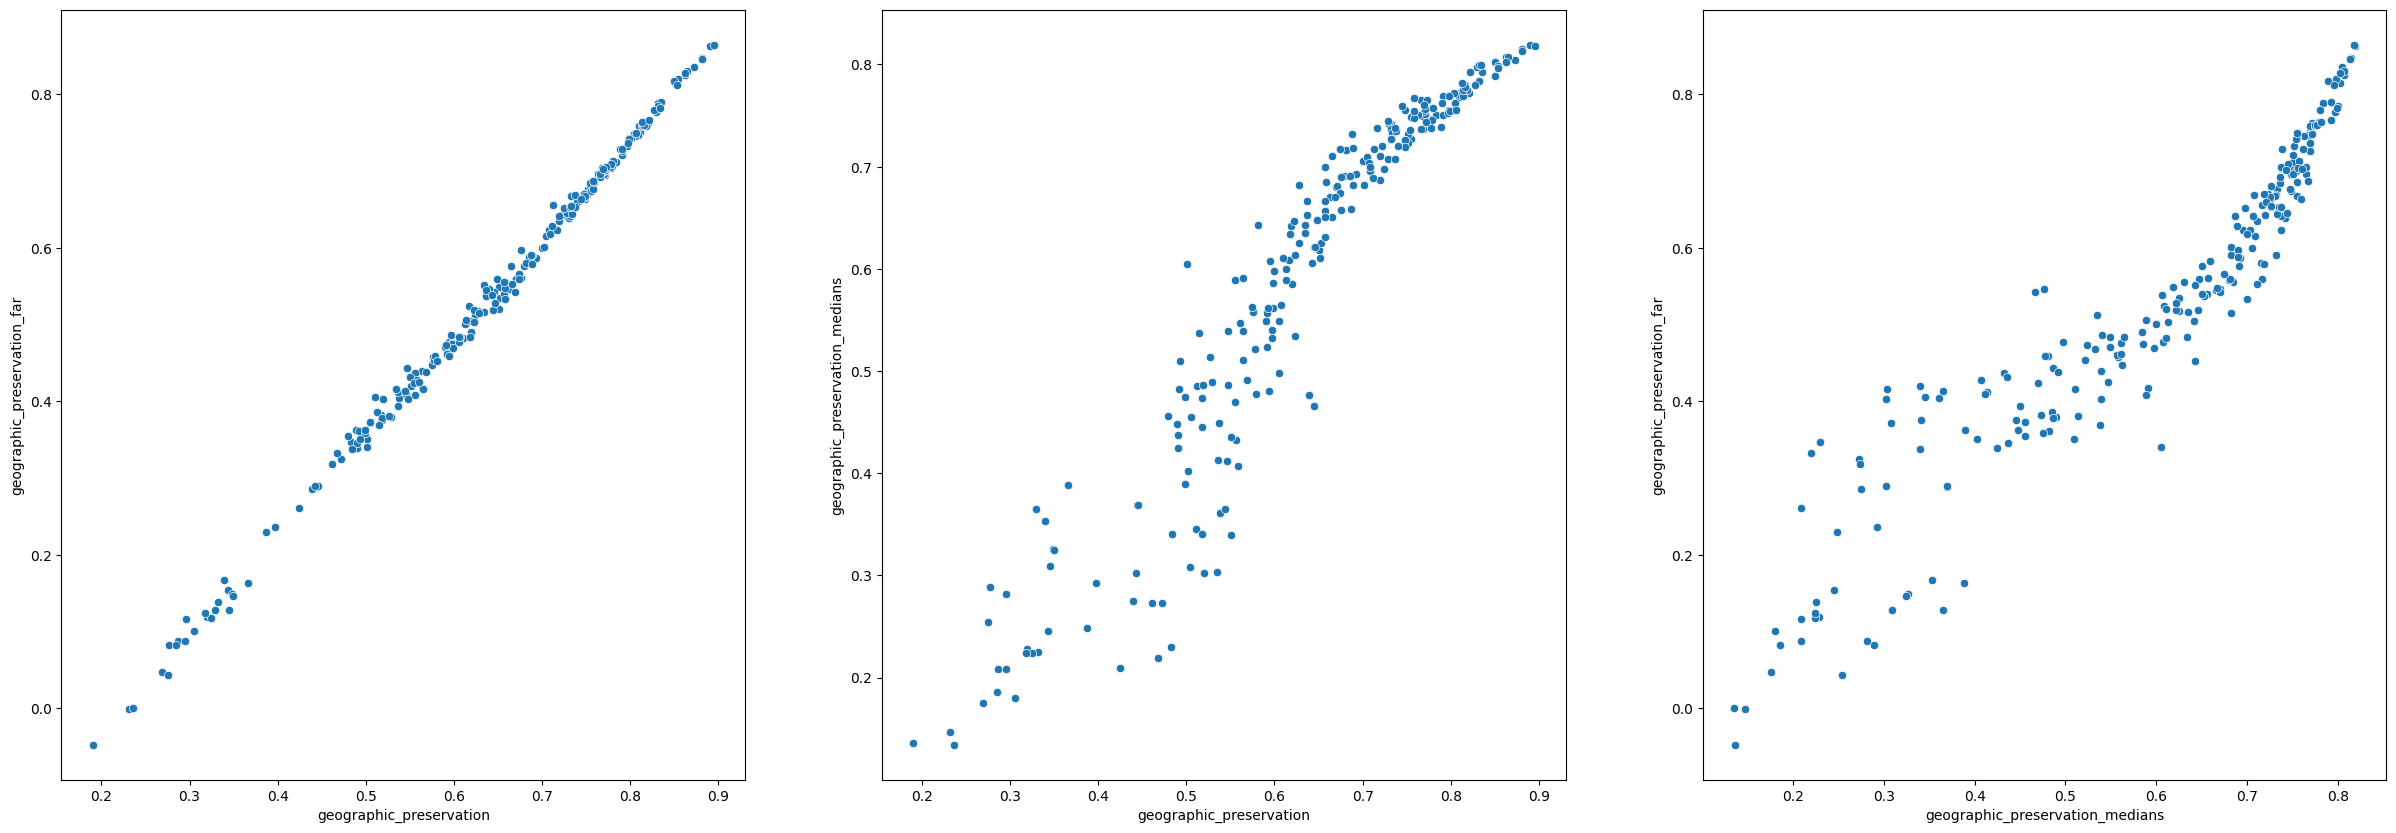

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))
sns.scatterplot(x=results['geographic_preservation'], y=results['geographic_preservation_far'], ax=ax[0])
sns.scatterplot(x=results['geographic_preservation'], y=results['geographic_preservation_medians'], ax=ax[1])
sns.scatterplot(x=results['geographic_preservation_medians'], y=results['geographic_preservation_far'], ax=ax[2])

<Axes: xlabel='admixture_preservation_medians_kmean', ylabel='admixture_preservation_far_kmean'>

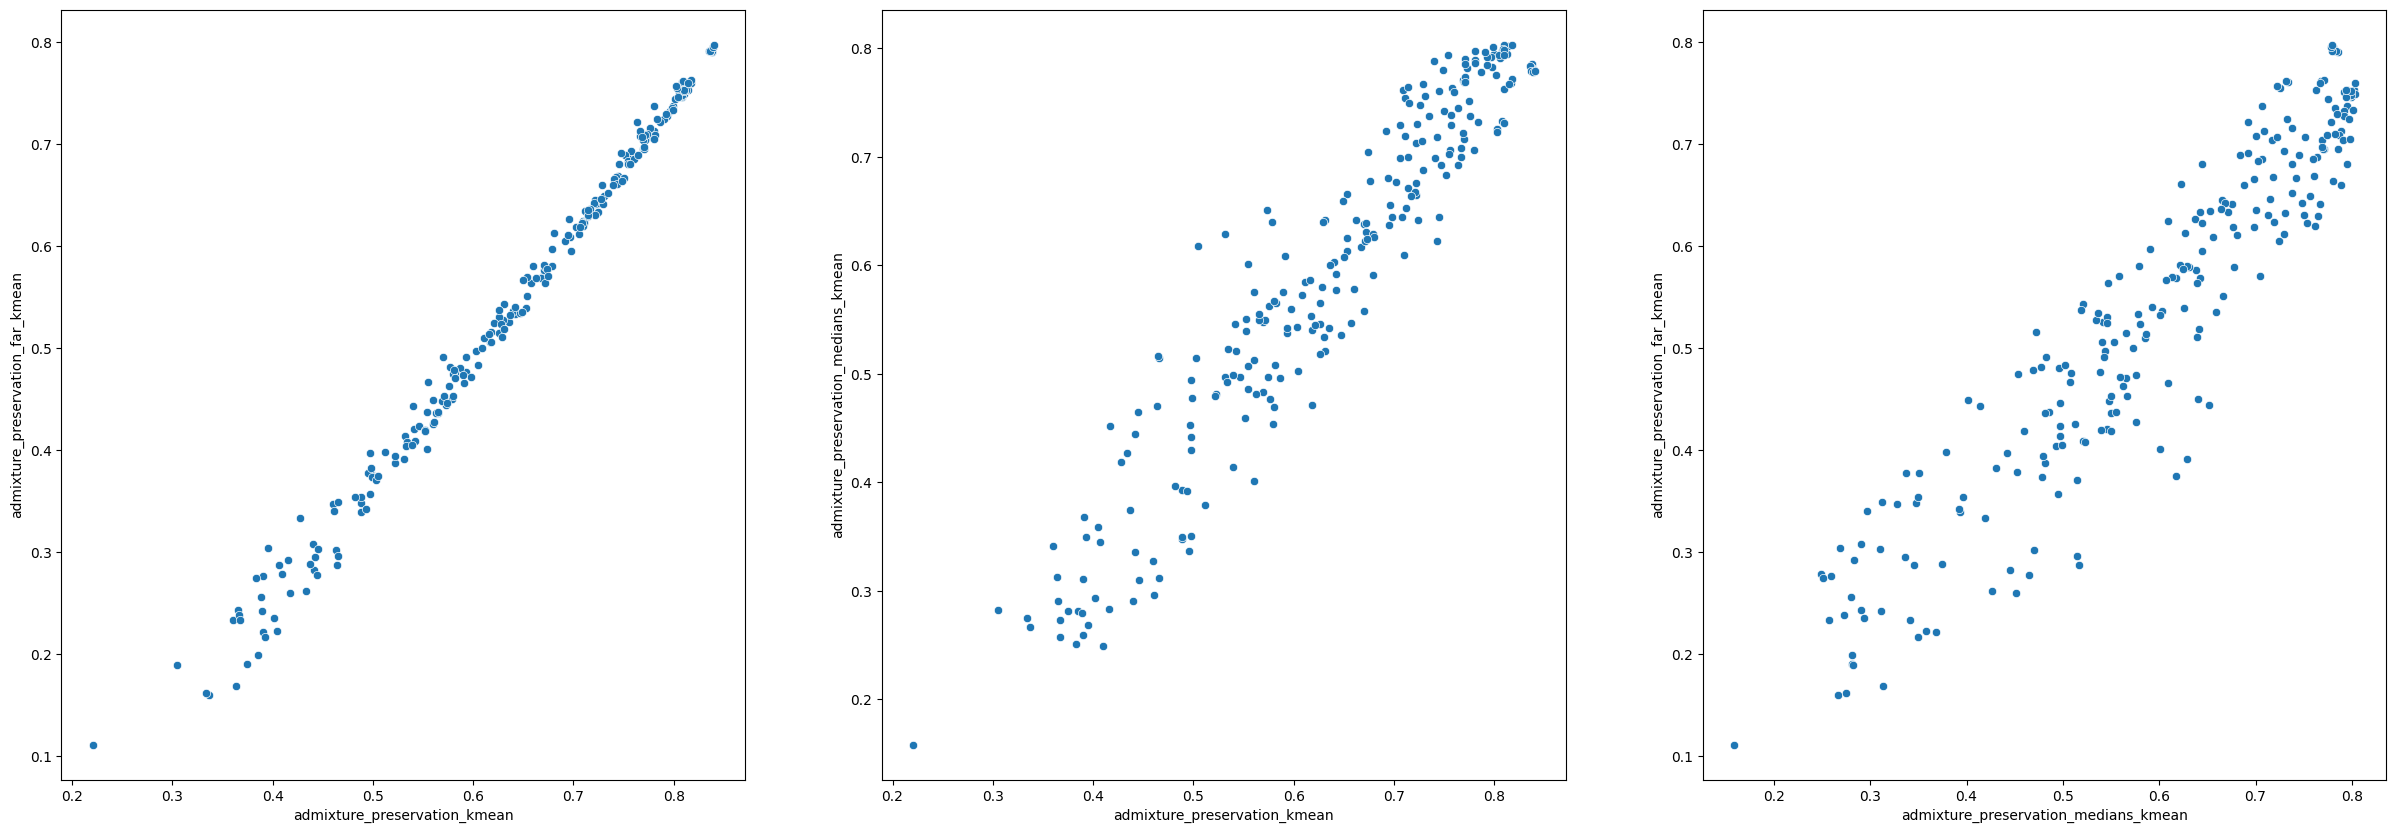

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))
sns.scatterplot(x=results['admixture_preservation_kmean'], y=results['admixture_preservation_far_kmean'], ax=ax[0])
sns.scatterplot(x=results['admixture_preservation_kmean'], y=results['admixture_preservation_medians_kmean'], ax=ax[1])
sns.scatterplot(x=results['admixture_preservation_medians_kmean'], y=results['admixture_preservation_far_kmean'], ax=ax[2])

<Axes: xlabel='admixture_preservation_far_kmean', ylabel='geographic_preservation_far'>

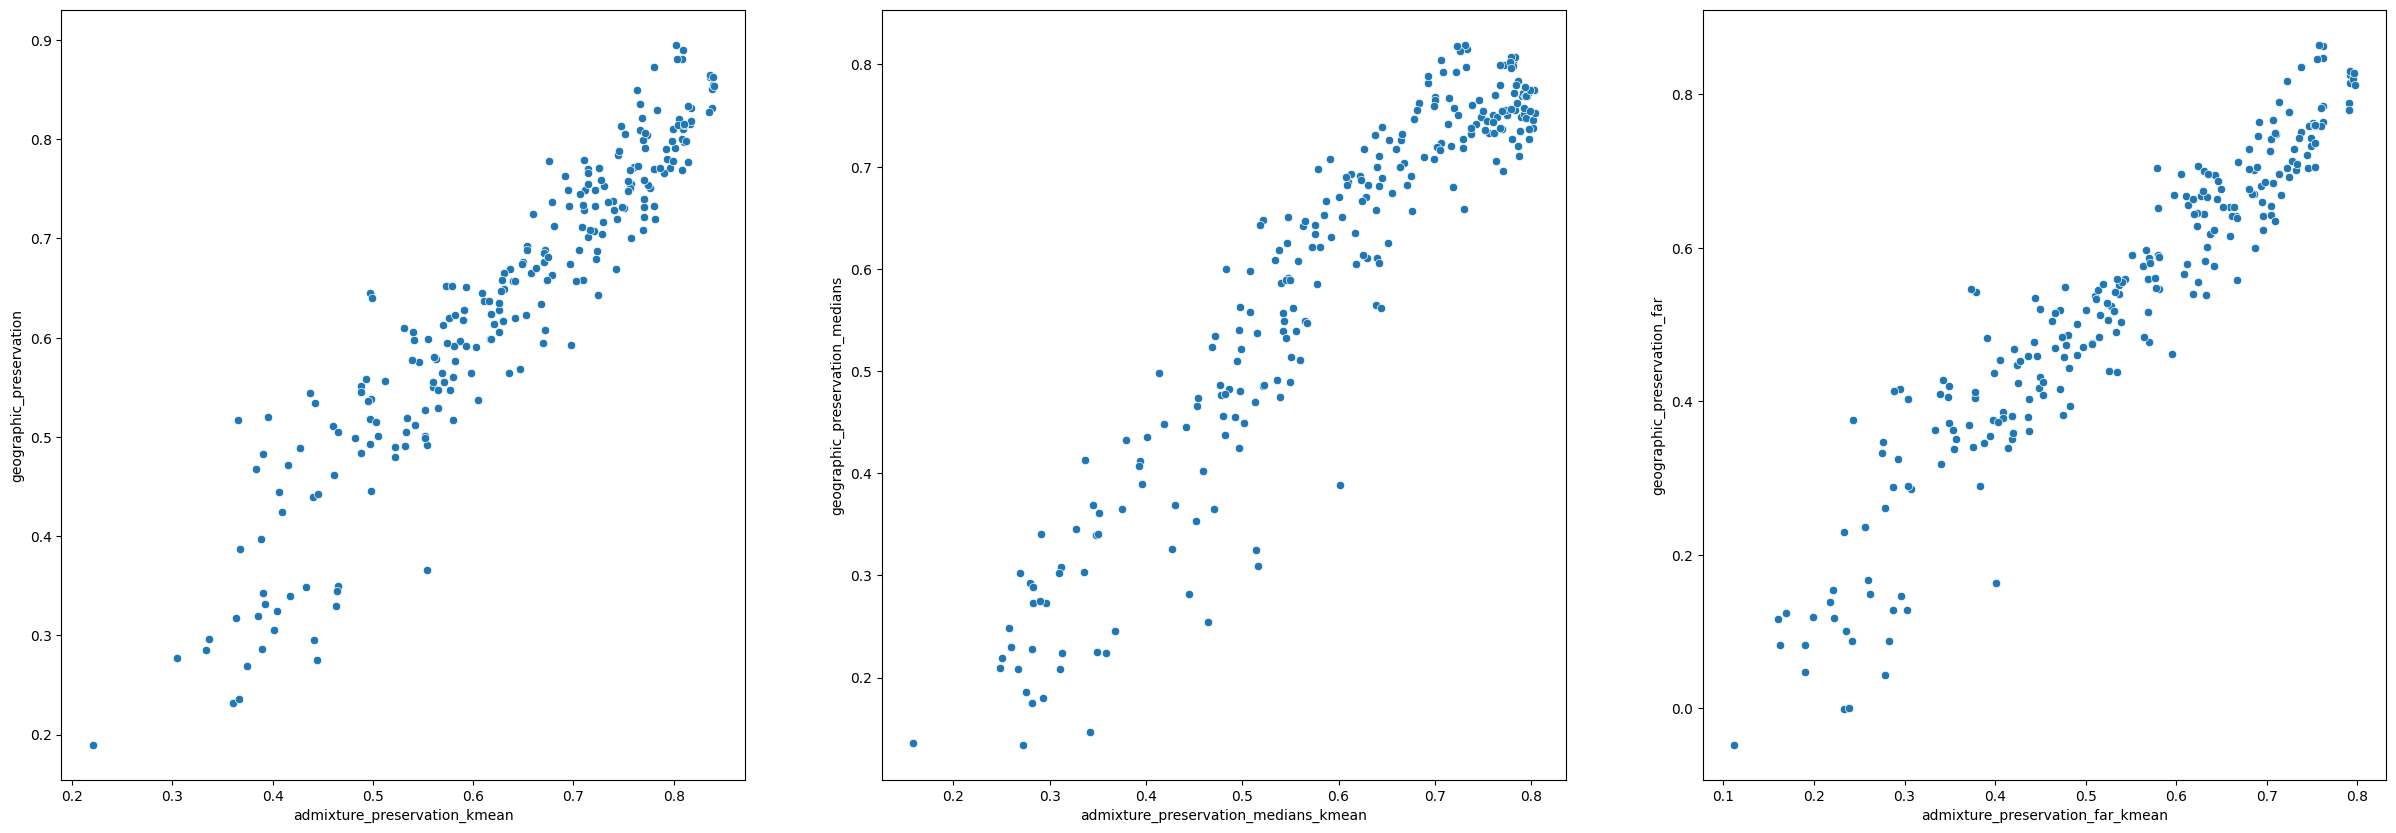

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))
sns.scatterplot(x=results['admixture_preservation_kmean'], y=results['geographic_preservation'], ax=ax[0])
sns.scatterplot(x=results['admixture_preservation_medians_kmean'], y=results['geographic_preservation_medians'], ax=ax[1])
sns.scatterplot(x=results['admixture_preservation_far_kmean'], y=results['geographic_preservation_far'], ax=ax[2])

## Compare Topological Proporties with Performance

<Axes: xlabel='connected_components', ylabel='pca_correlation'>

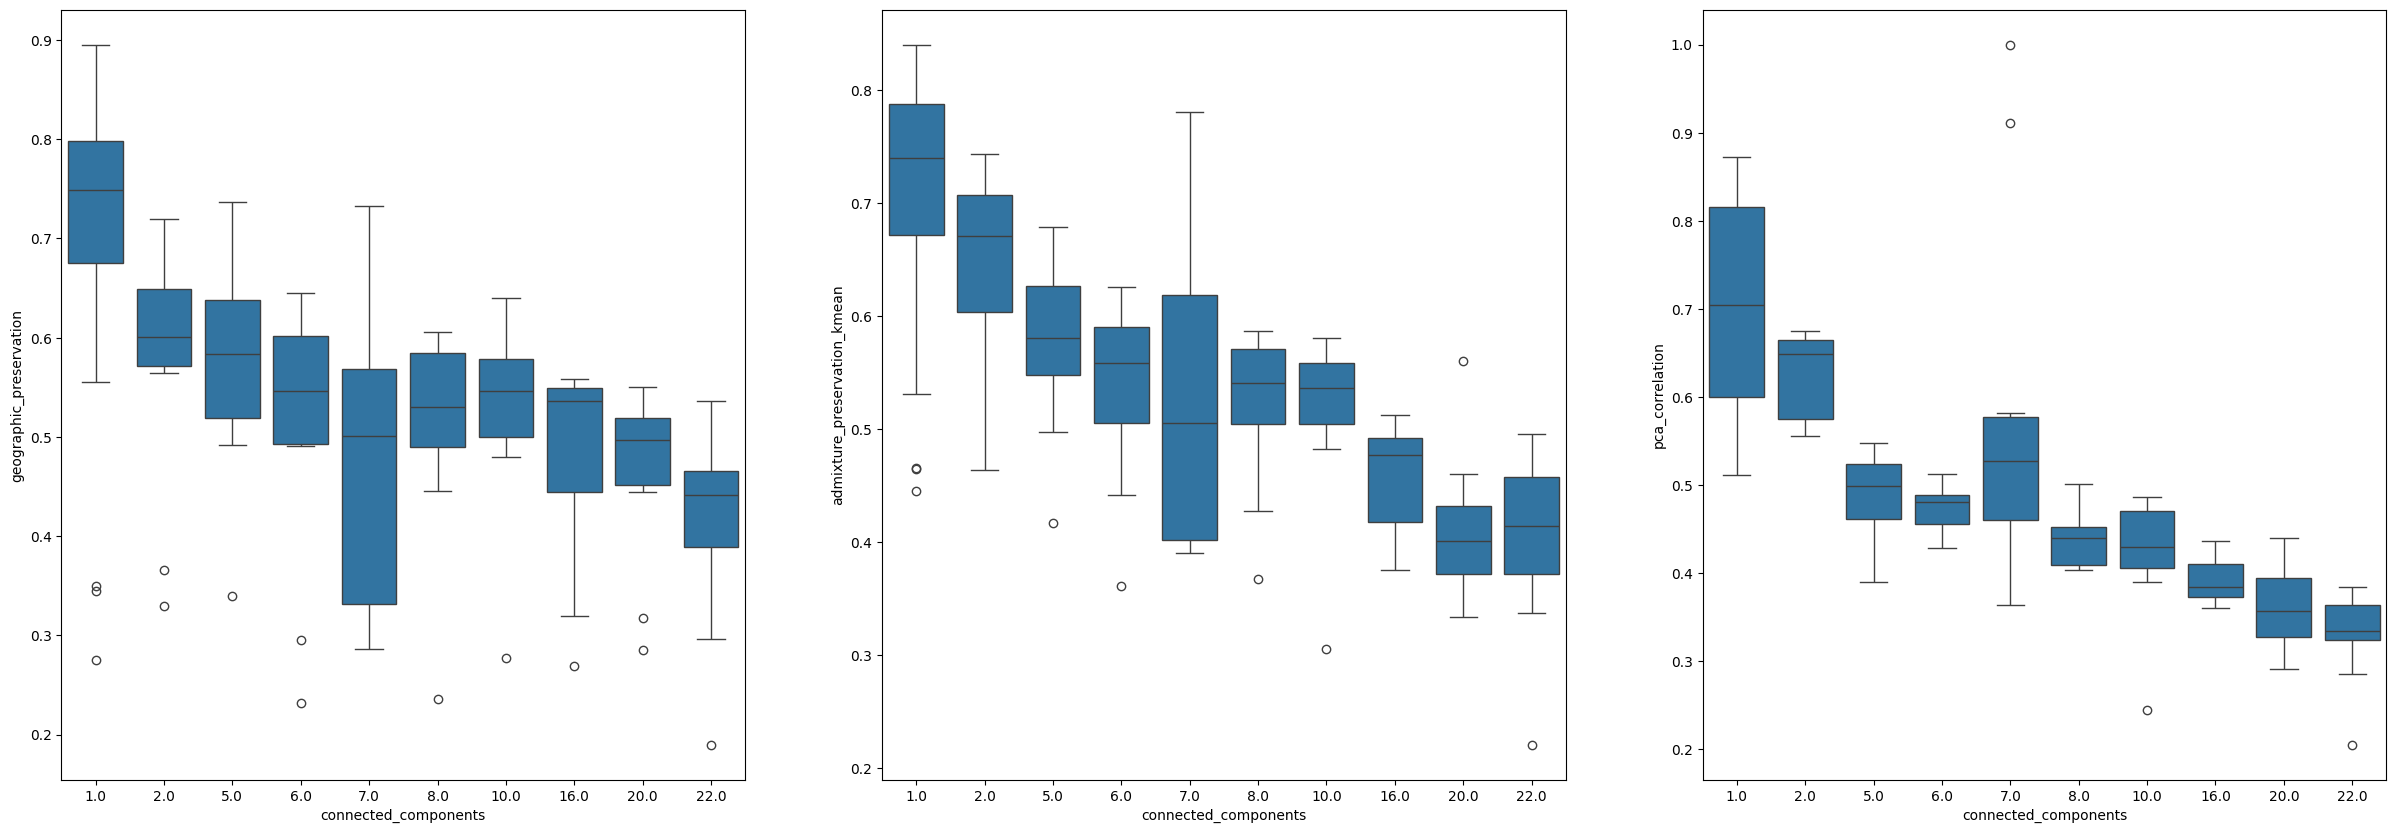

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))
sns.boxplot(x=results['connected_components'], y=results['geographic_preservation'], ax=ax[0])
sns.boxplot(x=results['connected_components'], y=results['admixture_preservation_kmean'], ax=ax[1])
sns.boxplot(x=results['connected_components'], y=results['pca_correlation'], ax=ax[2])

## Compare Hyperparameters with performance

Text(0, 0.5, 'gamma = 1')

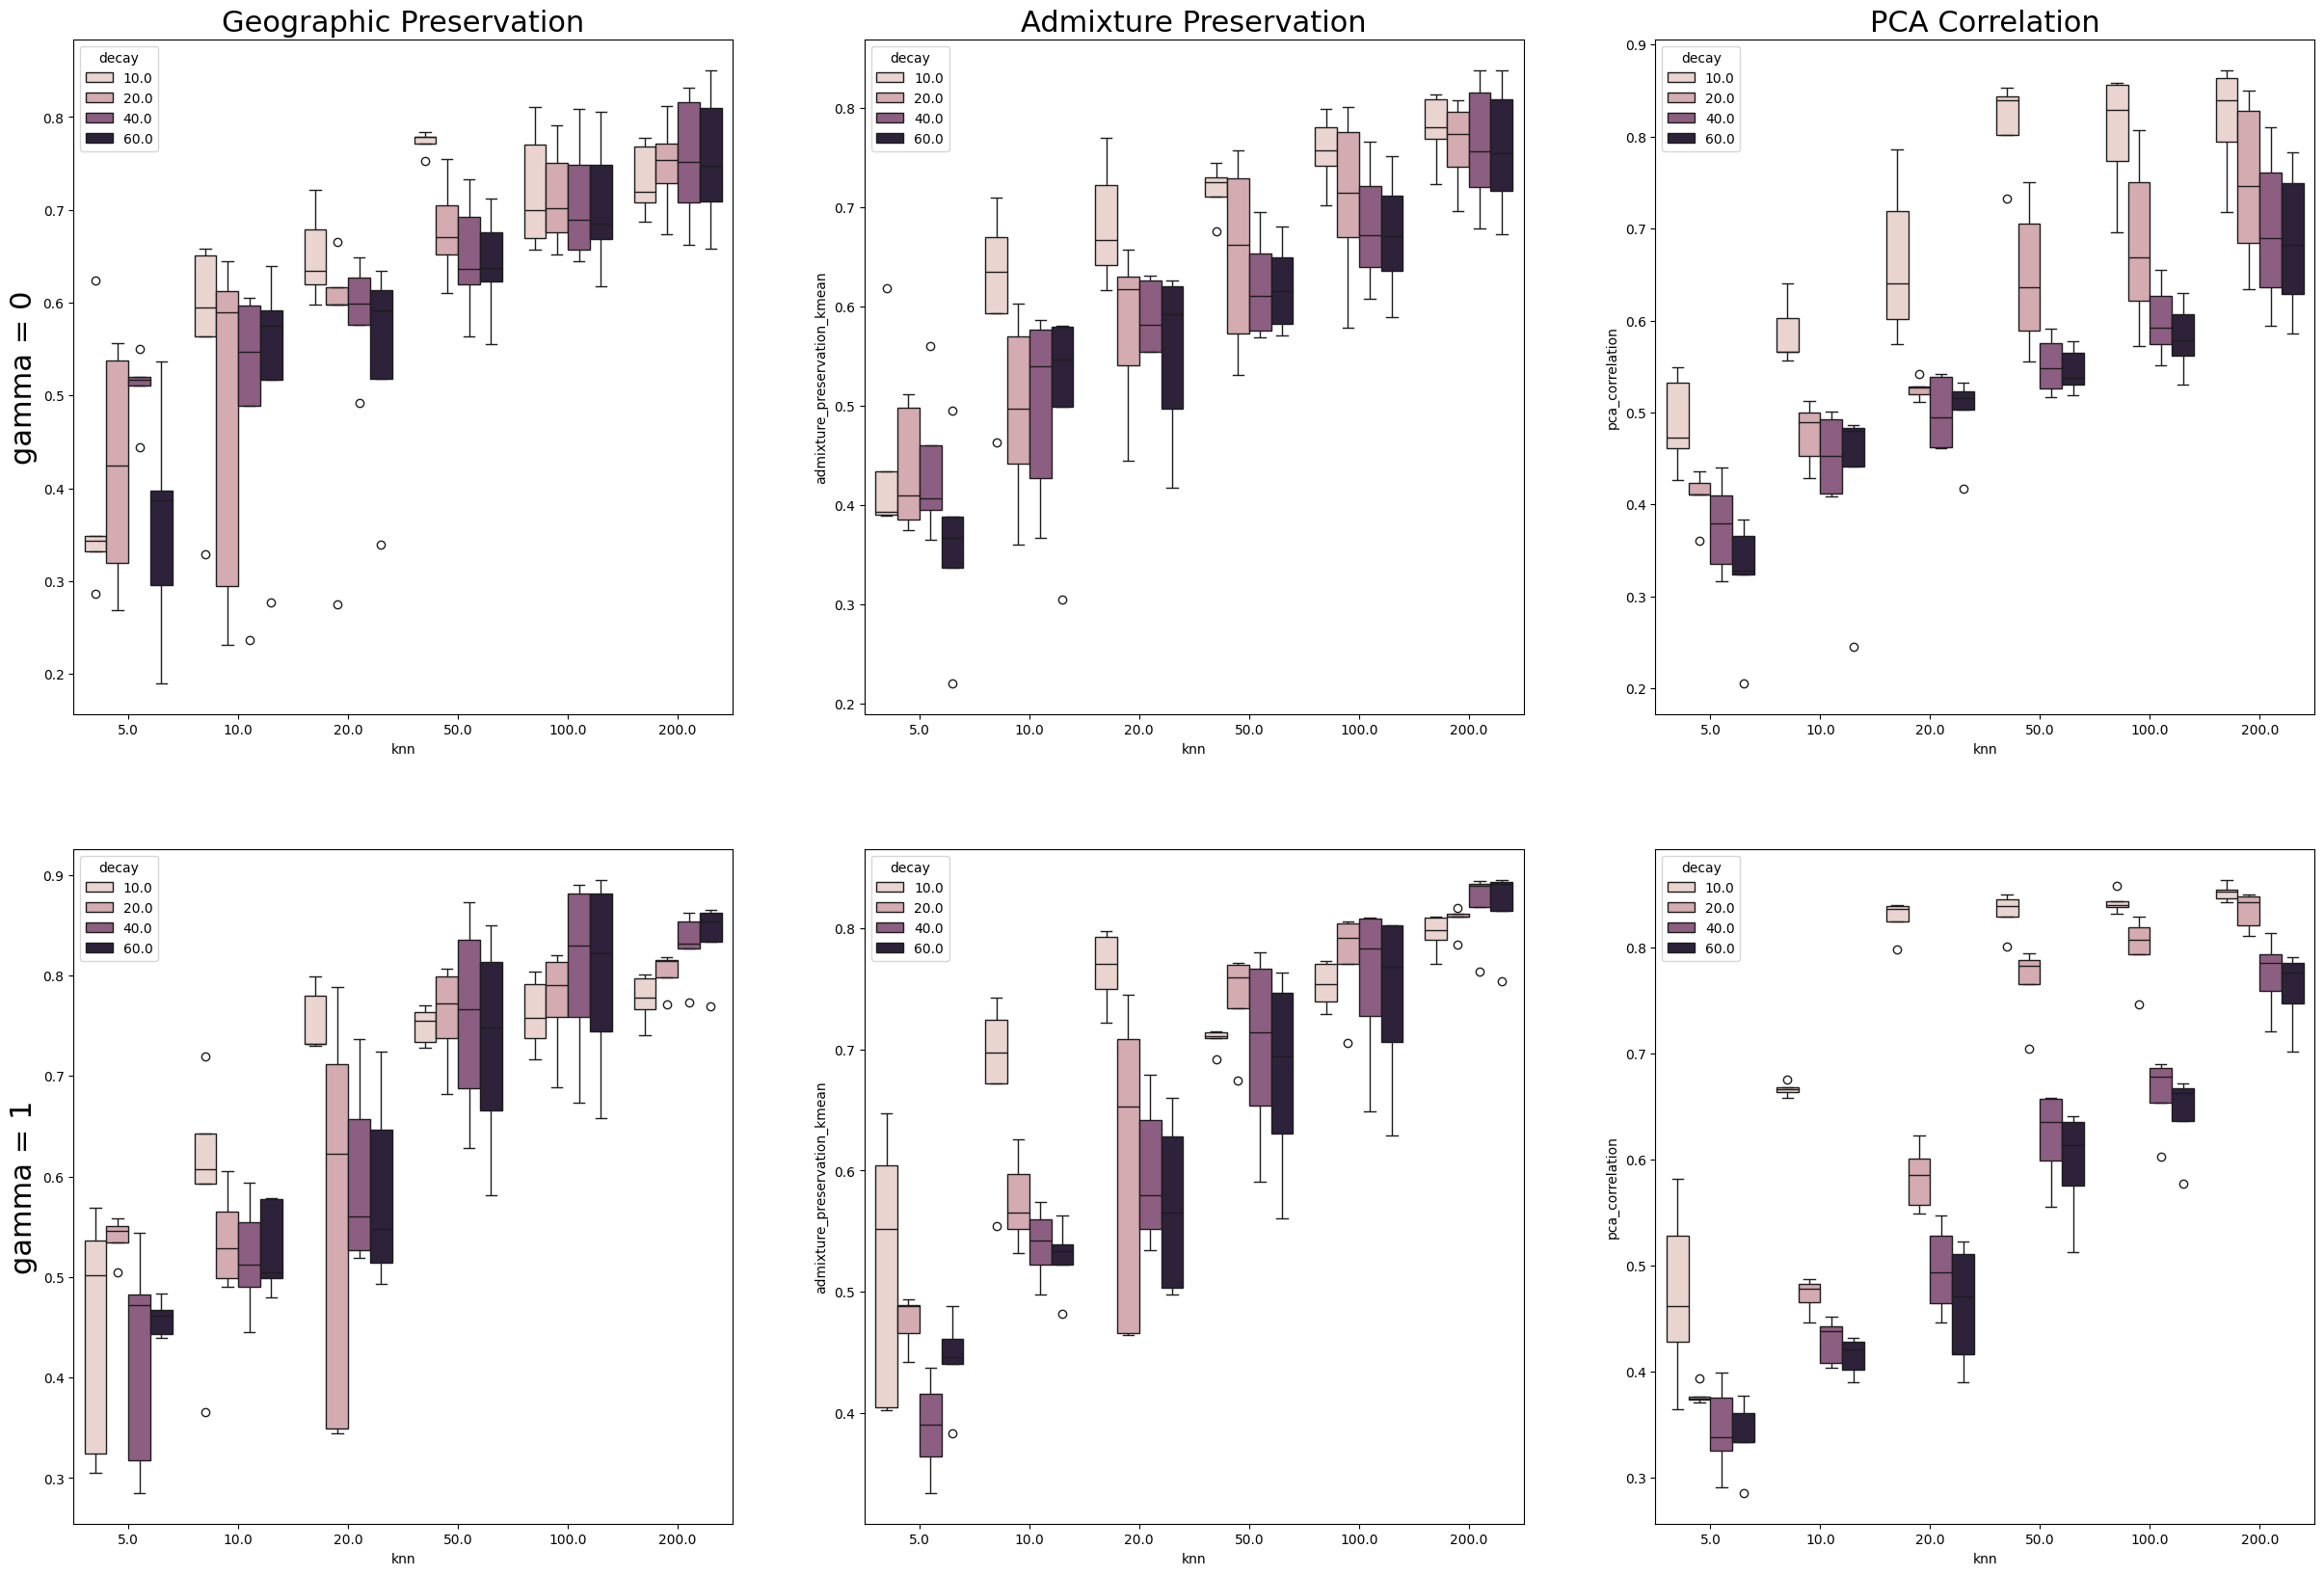

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(30,20))

sns.boxplot(x=results.query("gamma == 0")['knn'], y=results.query("gamma == 0")['geographic_preservation'], hue=results.query("gamma == 0")['decay'], ax=ax[0,0])
sns.boxplot(x=results.query("gamma == 0")['knn'], y=results.query("gamma == 0")['admixture_preservation_kmean'], hue=results.query("gamma == 0")['decay'], ax=ax[0,1])
sns.boxplot(x=results.query("gamma == 0")['knn'], y=results.query("gamma == 0")['pca_correlation'], hue=results.query("gamma == 0")['decay'], ax=ax[0,2])
ax[0,0].set_ylabel('gamma = 0', fontsize=22)

ax[0,0].set_title('Geographic Preservation', fontsize=22)
ax[0,1].set_title('Admixture Preservation', fontsize=22)
ax[0,2].set_title('PCA Correlation', fontsize=22)

sns.boxplot(x=results.query("gamma == 1")['knn'], y=results.query("gamma == 1")['geographic_preservation'], hue=results.query("gamma == 1")['decay'], ax=ax[1,0])
sns.boxplot(x=results.query("gamma == 1")['knn'], y=results.query("gamma == 1")['admixture_preservation_kmean'], hue=results.query("gamma == 1")['decay'], ax=ax[1,1])
sns.boxplot(x=results.query("gamma == 1")['knn'], y=results.query("gamma == 1")['pca_correlation'], hue=results.query("gamma == 1")['decay'], ax=ax[1,2])
ax[1,0].set_ylabel('gamma = 1', fontsize=22)

<Axes: xlabel='knn', ylabel='pca_correlation'>

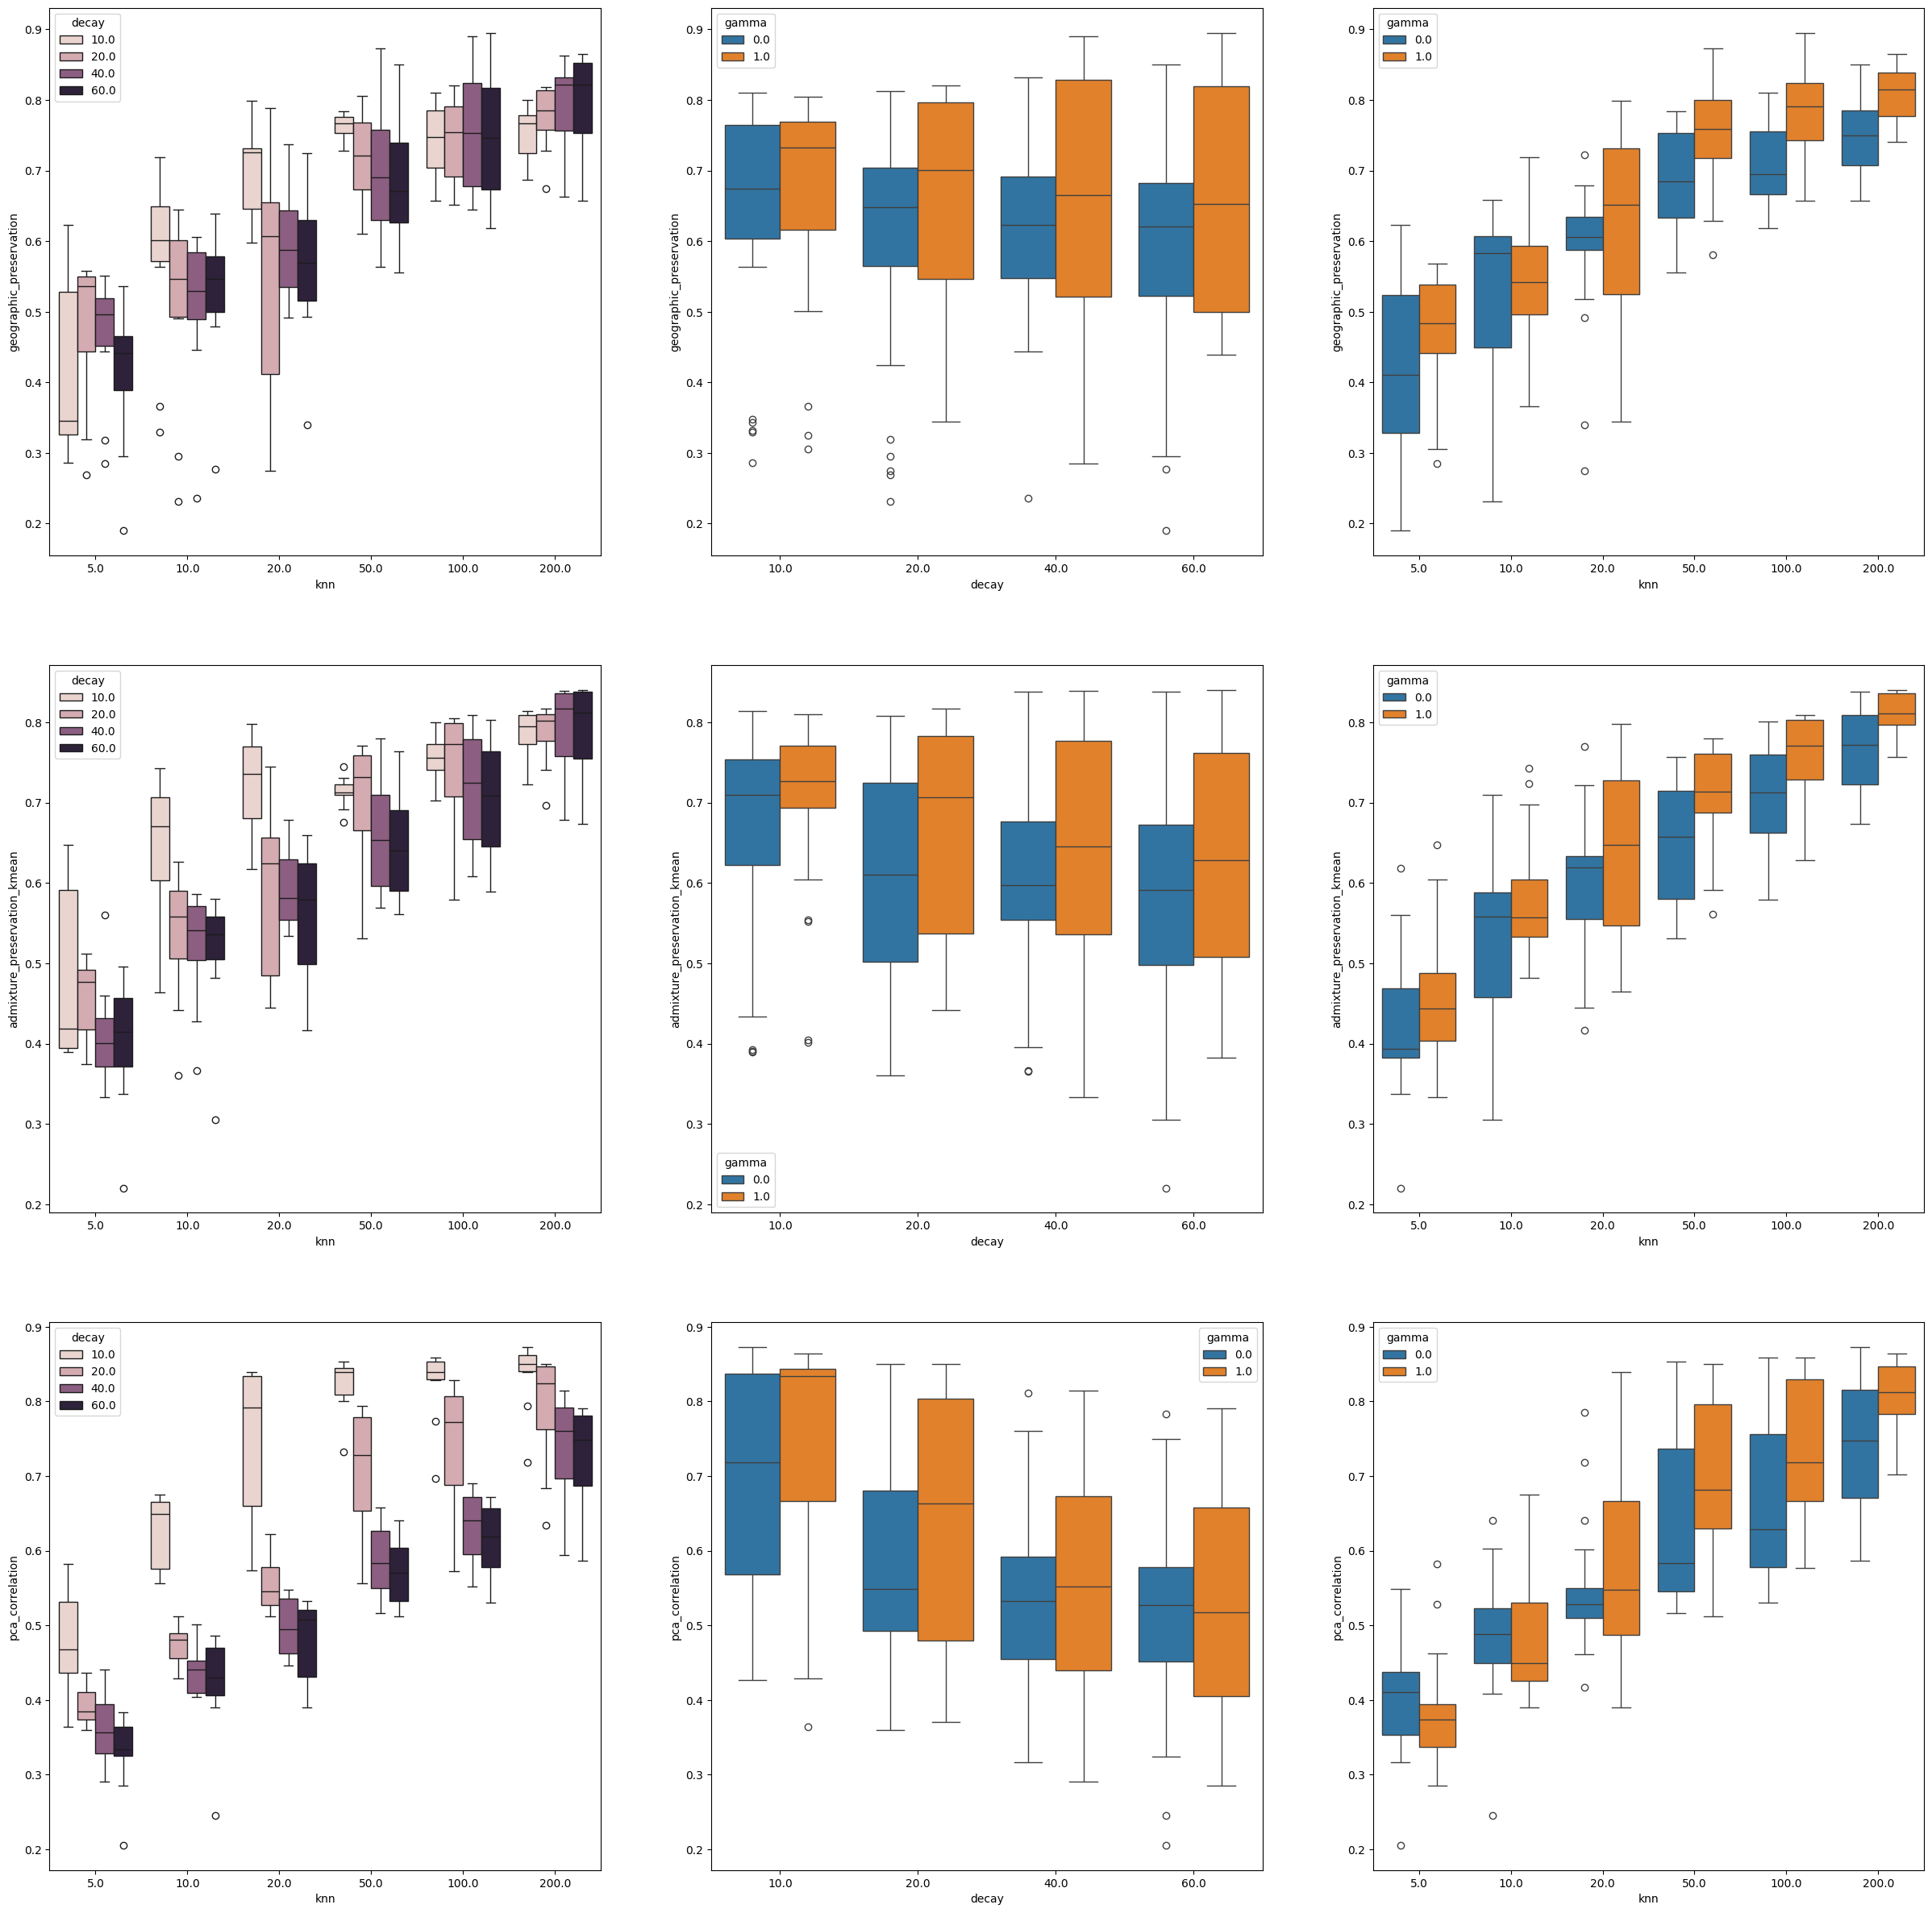

In [13]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(30,30))
sns.boxplot(x=results['knn'], y=results['geographic_preservation'], hue=results['decay'], ax=ax[0,0])
sns.boxplot(x=results['knn'], y=results['admixture_preservation_kmean'], hue=results['decay'], ax=ax[1,0])
sns.boxplot(x=results['knn'], y=results['pca_correlation'], hue=results['decay'], ax=ax[2,0])

sns.boxplot(x=results['decay'], y=results['geographic_preservation'], hue=results['gamma'], ax=ax[0,1])
sns.boxplot(x=results['decay'], y=results['admixture_preservation_kmean'], hue=results['gamma'], ax=ax[1,1])
sns.boxplot(x=results['decay'], y=results['pca_correlation'], hue=results['gamma'], ax=ax[2,1])

sns.boxplot(x=results['knn'], y=results['geographic_preservation'], hue=results['gamma'], ax=ax[0,2])
sns.boxplot(x=results['knn'], y=results['admixture_preservation_kmean'], hue=results['gamma'], ax=ax[1,2])
sns.boxplot(x=results['knn'], y=results['pca_correlation'], hue=results['gamma'], ax=ax[2,2])

<Axes: xlabel='t', ylabel='geographic_preservation'>

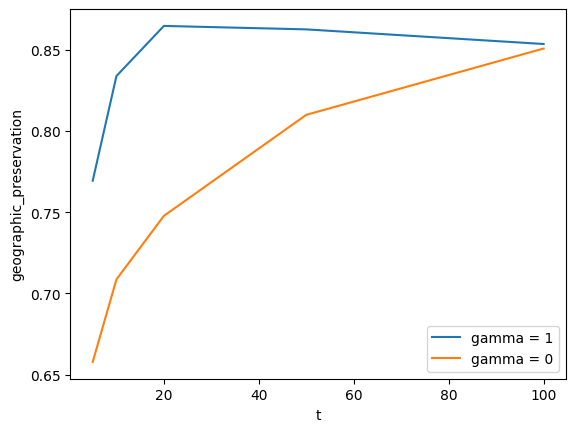

In [14]:
sns.lineplot(x=results.query('gamma == 1 & decay == 60 & knn == 200')['t'],
             y=results.query('gamma == 1 & decay == 60 & knn == 200')['geographic_preservation'], label='gamma = 1')

sns.lineplot(x=results.query('gamma == 0 & decay == 60 & knn == 200')['t'],
             y=results.query('gamma == 0 & decay == 60 & knn == 200')['geographic_preservation'], label='gamma = 0')

(0.4, 1.0)

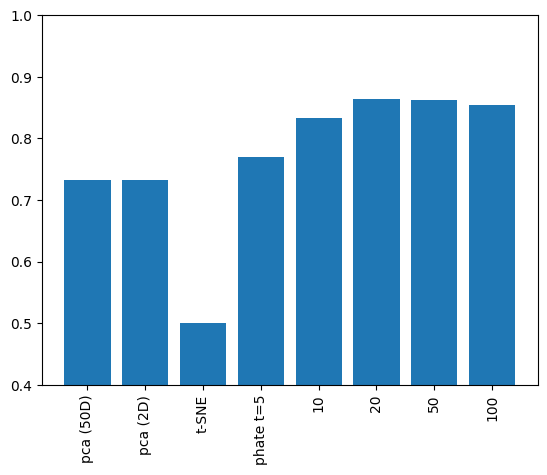

In [15]:
heights = results.query('method == "pca (50D)"')['geographic_preservation'].tolist() + \
          results.query('method == "pca (2D)"')['geographic_preservation'].tolist() + \
          results.query('method == "t-SNE"')['geographic_preservation'].tolist() + \
          results.query('gamma == 1 & decay == 60 & knn == 200')['geographic_preservation'].tolist()

plt.bar(x=['pca (50D)', 'pca (2D)', 't-SNE', 'phate t=5','10','20','50','100'], 
        height=heights)
_ = plt.xticks(rotation=90)
plt.ylim(0.4, 1) 

(0.4, 1.0)

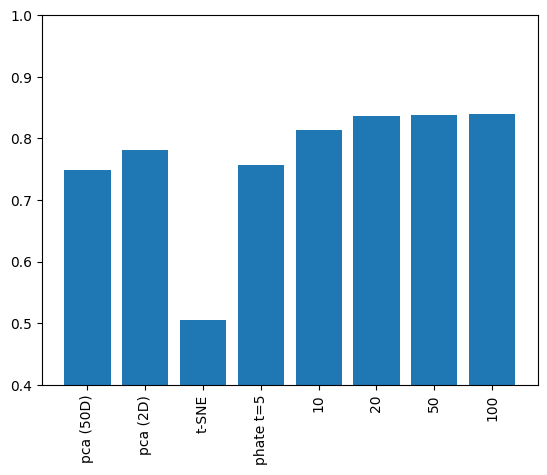

In [16]:
heights = results.query('method == "pca (50D)"')['admixture_preservation_kmean'].tolist() + \
          results.query('method == "pca (2D)"')['admixture_preservation_kmean'].tolist() + \
          results.query('method == "t-SNE"')['admixture_preservation_kmean'].tolist() + \
          results.query('gamma == 1 & decay == 60 & knn == 200')['admixture_preservation_kmean'].tolist()

plt.bar(x=['pca (50D)', 'pca (2D)', 't-SNE', 'phate t=5','10','20','50','100'], 
        height=heights)
_ = plt.xticks(rotation=90)
plt.ylim(0.4, 1) 

(0.2, 1.0)

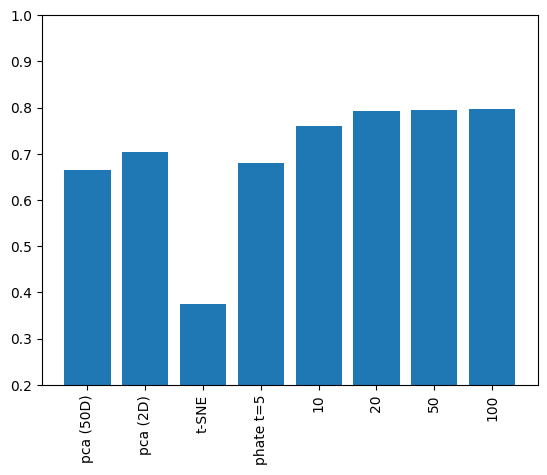

In [17]:
heights = results.query('method == "pca (50D)"')['admixture_preservation_far_kmean'].tolist() + \
          results.query('method == "pca (2D)"')['admixture_preservation_far_kmean'].tolist() + \
          results.query('method == "t-SNE"')['admixture_preservation_far_kmean'].tolist() + \
          results.query('gamma == 1 & decay == 60 & knn == 200')['admixture_preservation_far_kmean'].tolist()

plt.bar(x=['pca (50D)', 'pca (2D)', 't-SNE', 'phate t=5','10','20','50','100'], 
        height=heights)
_ = plt.xticks(rotation=90)
plt.ylim(0.2, 1) 

## Show Metrics

In [18]:
from sklearn.manifold import TSNE
import pickle

index = fit_idx | transform_idx

tsne_obj = TSNE(n_components=2, init='pca')
tsne_emb = np.zeros(shape=(len(pca_input), 2))
tsne_out = tsne_obj.fit_transform(pca_input[index])
tsne_emb[index] = tsne_out

In [19]:
file_path = os.path.join('results/models', 'phate_n_landmark_None_knn_200_decay_60_gamma_1.pkl')

with open(file_path, 'rb') as f:
    phate_obj = pickle.load(f)
phate_obj.set_params(t=20)

phate_emb = np.zeros(shape=(len(pca_input), 2))
phate_emb[index] = phate_obj.transform(pca_input[index])

Calculating diffusion potential...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated diffusion potential in 8.20 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.74 seconds.
Calculating KNN search...
Calculated KNN search in 1.42 seconds.
Calculating affinities...
Calculated affinities in 0.26 seconds.


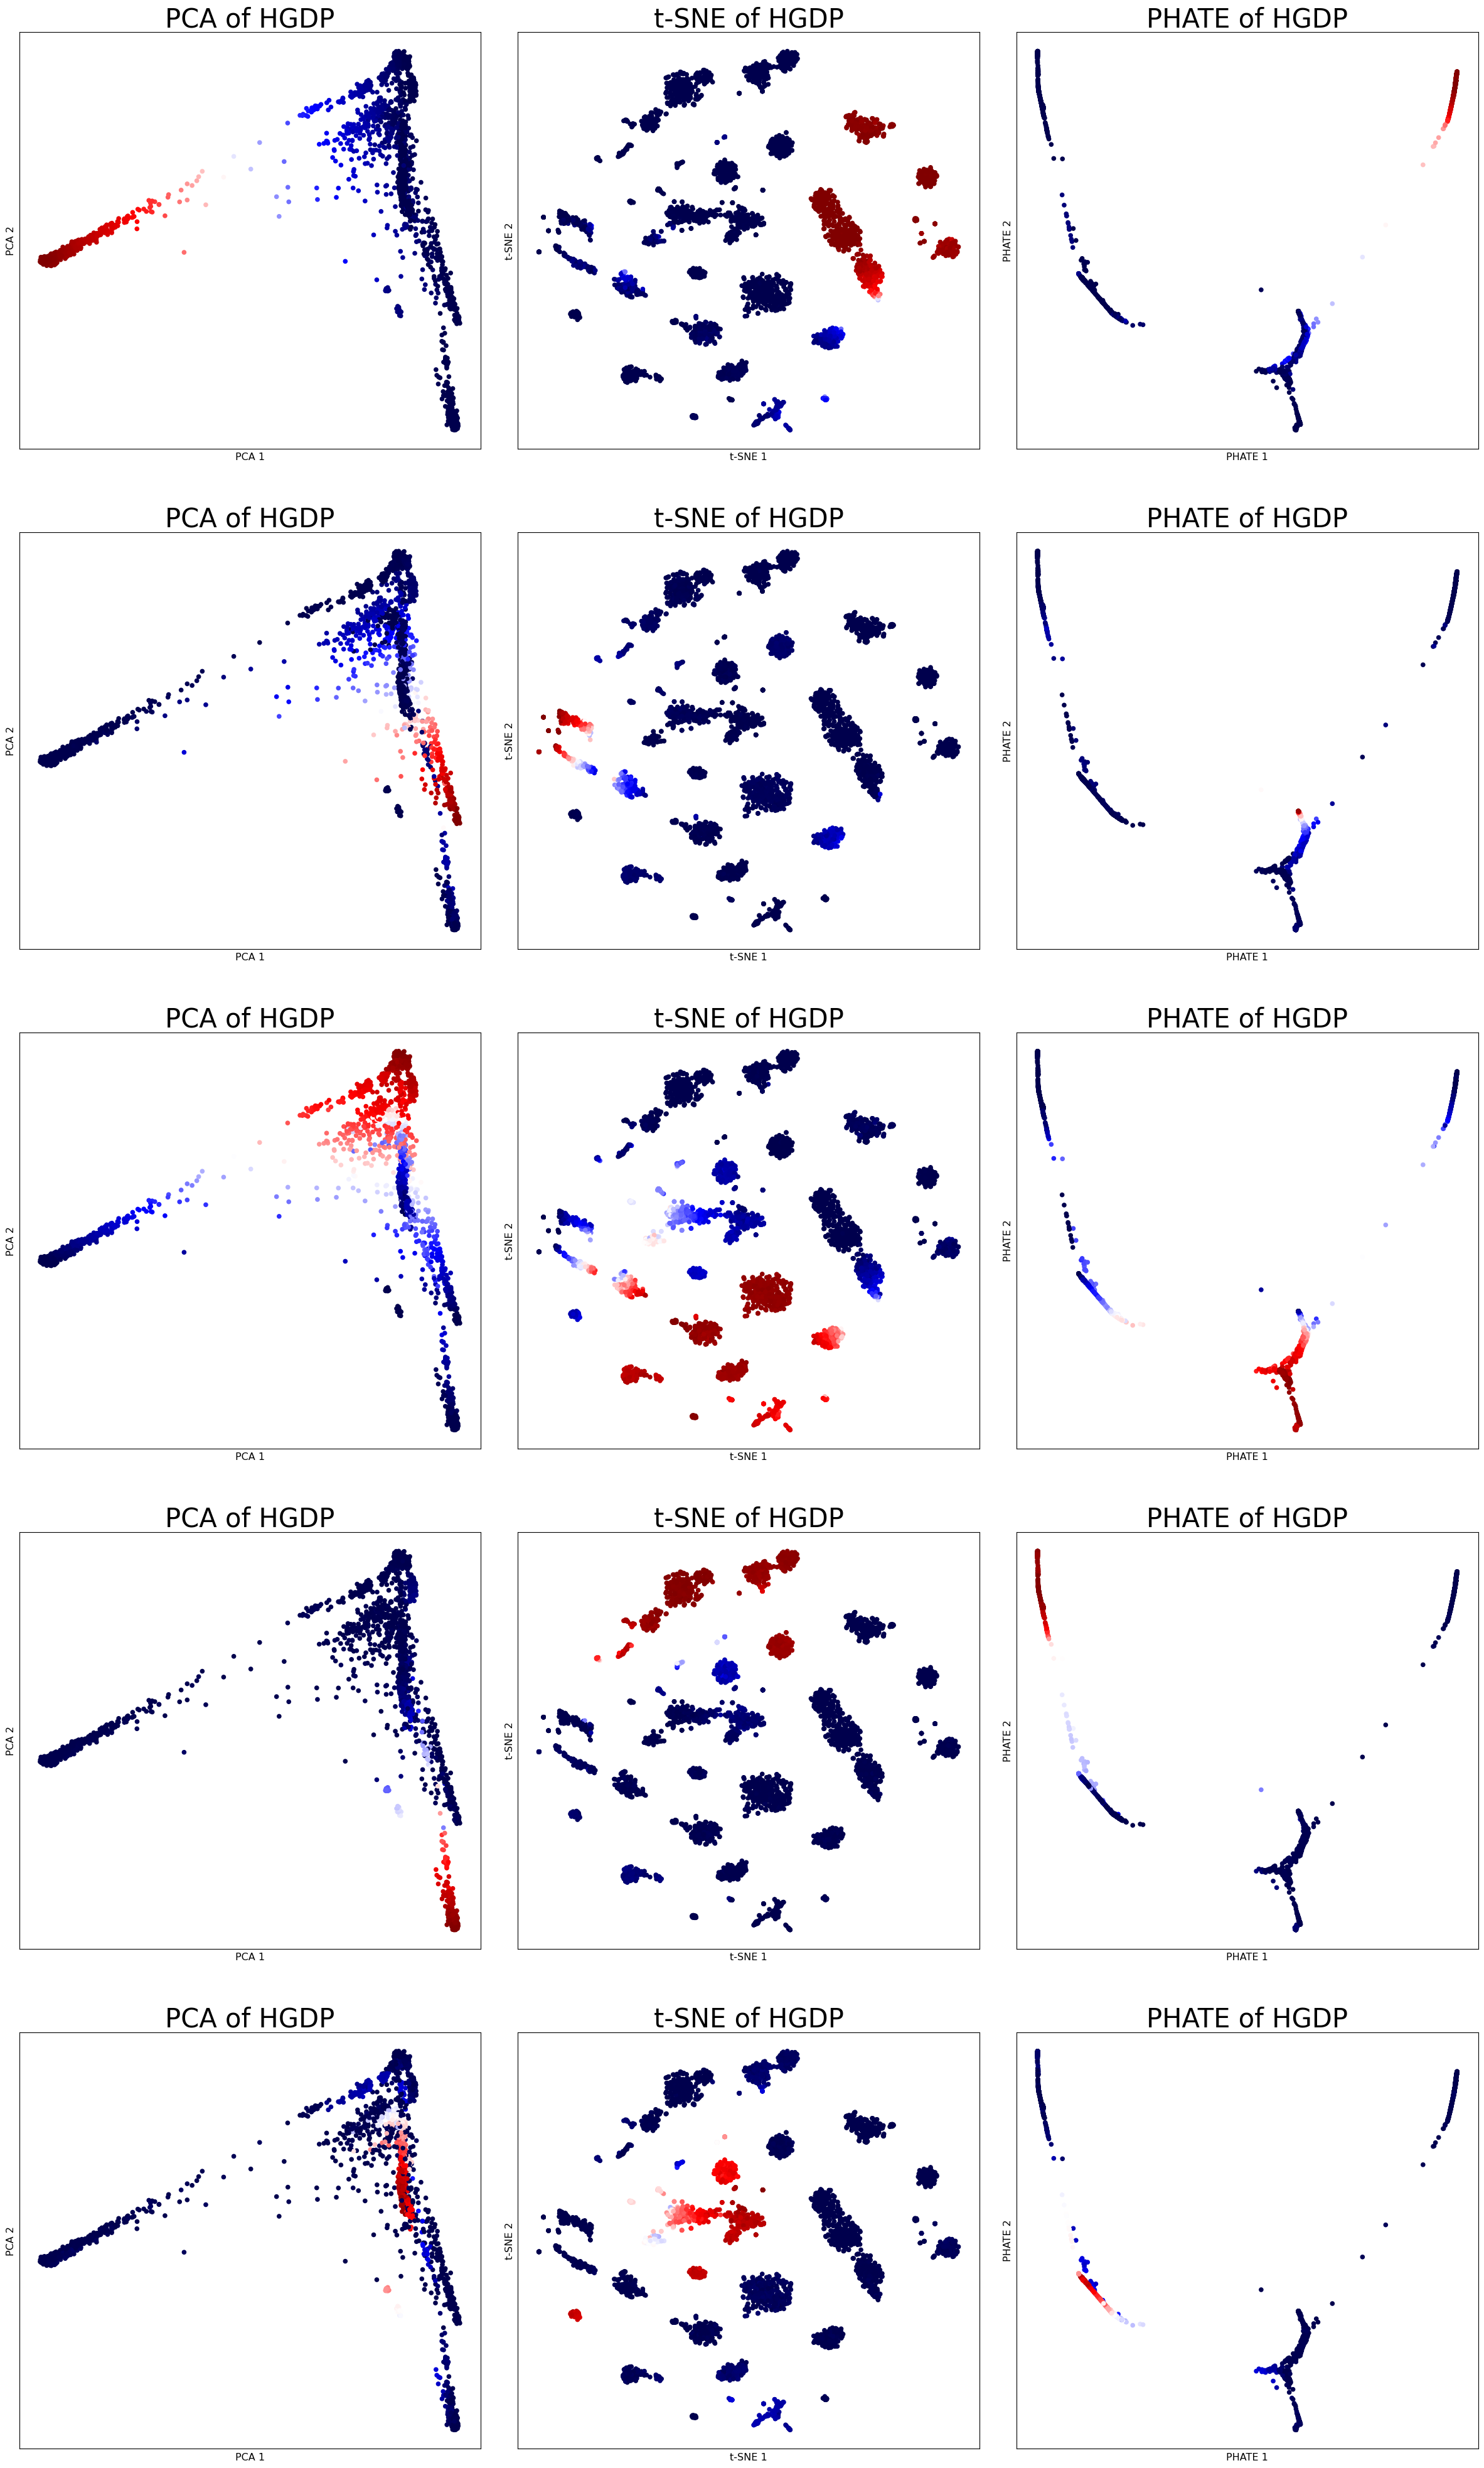

In [20]:
plot_admixtures(pca_input[index, :2],
                tsne_emb[index], 
                phate_emb[index], 
                admixture_ratios_list[3][index]) # K=5 for visualization

In [21]:
# Try t-SNE on PHATE initialization

tsne_obj2 = TSNE(n_components=2, init=phate_emb[index], learning_rate=100.0, n_iter=500)
tsne_emb2 = np.zeros(shape=(len(pca_input), 2))
tsne_out2 = tsne_obj2.fit_transform(pca_input[index])
tsne_emb2[index] = tsne_out2

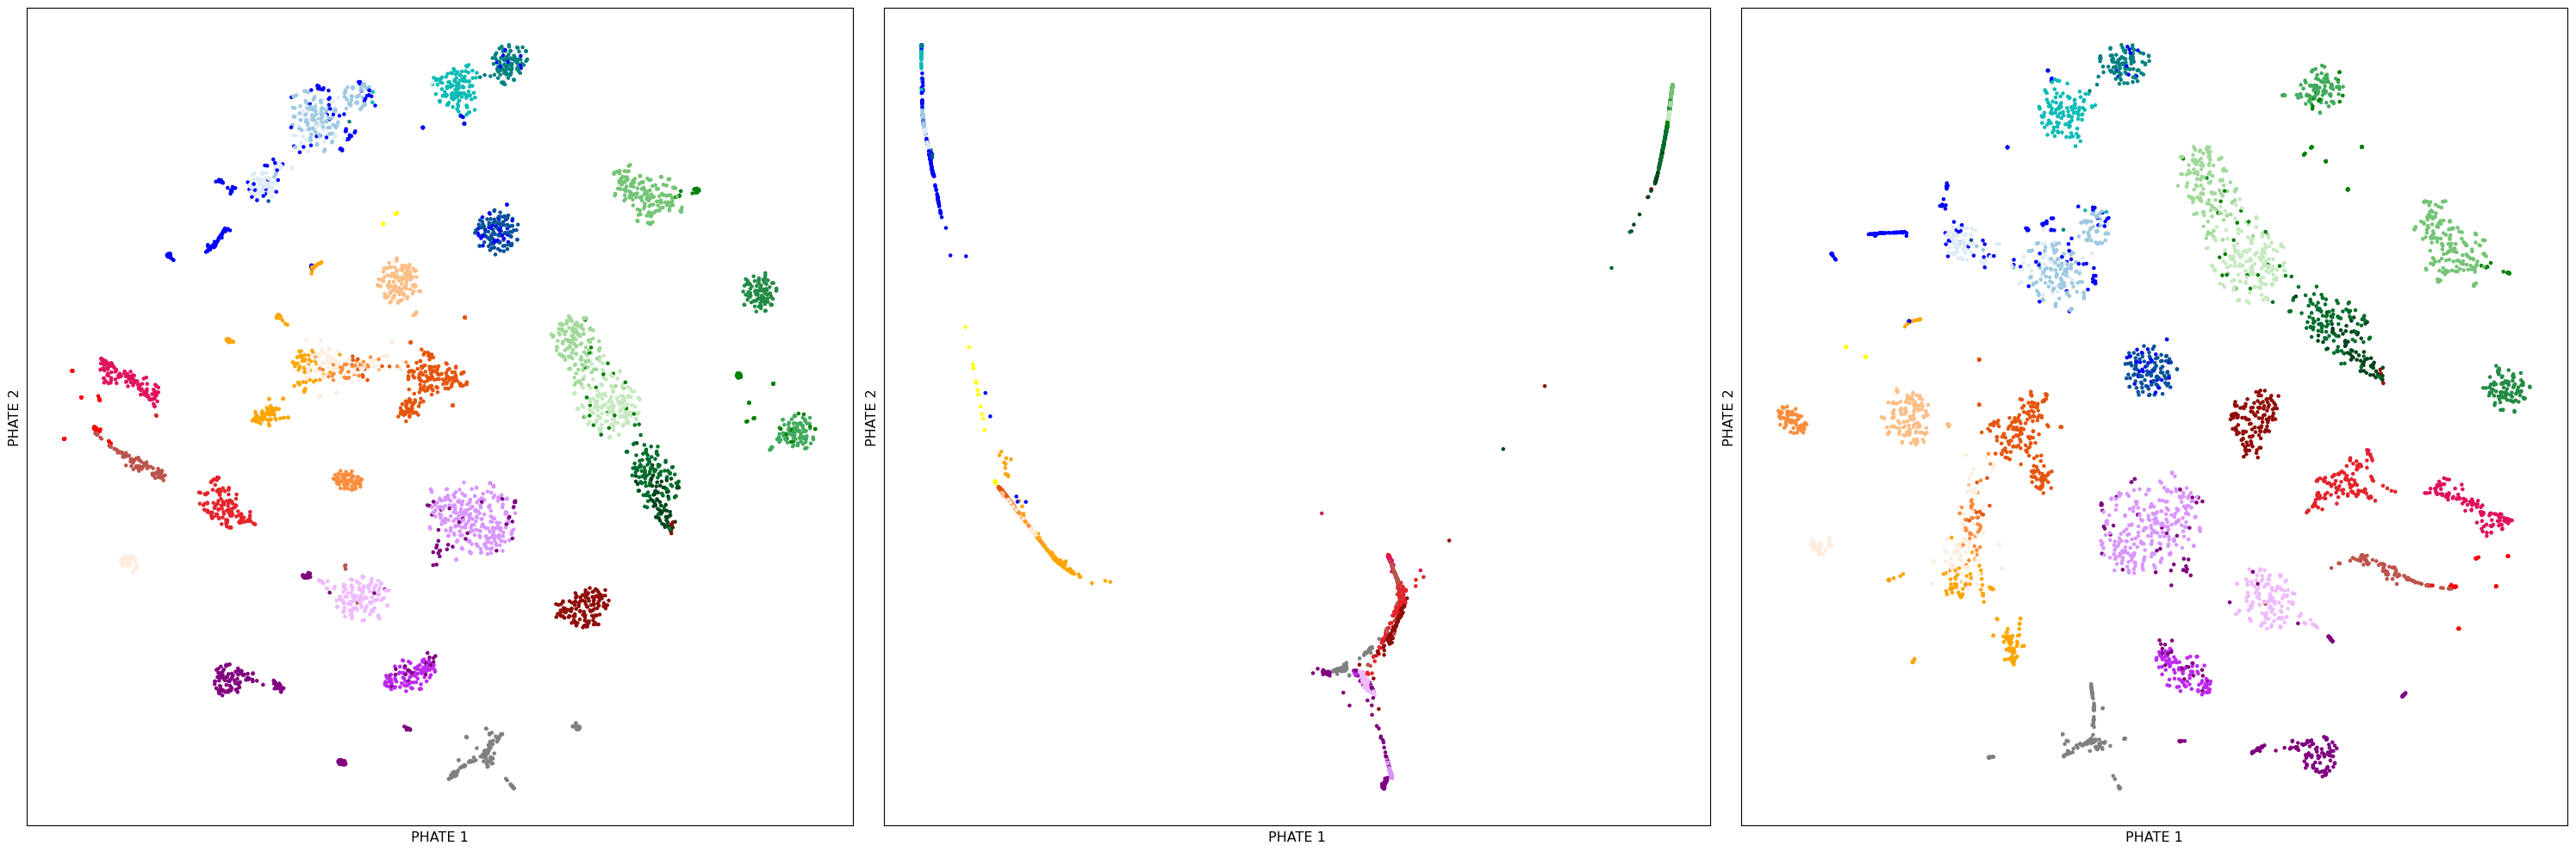

In [22]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))

scprep.plot.scatter2d(
                tsne_emb[index],
                s=5,
                ax=ax[0],
                c=metadata['Population'].values[index],
                cmap=cmap,
                xticks=False,
                yticks=False,
                legend=False,
                legend_loc='lower center',
                legend_anchor=(0.5, -0.35),
                legend_ncol=8,
                label_prefix="PHATE ",
                fontsize=8)

scprep.plot.scatter2d(
                phate_emb[index],
                s=5,
                ax=ax[1],
                c=metadata['Population'].values[index],
                cmap=cmap,
                xticks=False,
                yticks=False,
                legend=False,
                legend_loc='lower center',
                legend_anchor=(0.5, -0.35),
                legend_ncol=8,
                label_prefix="PHATE ",
                fontsize=8)

scprep.plot.scatter2d(
                tsne_emb2[index],
                s=5,
                ax=ax[2],
                c=metadata['Population'].values[index],
                cmap=cmap,
                xticks=False,
                yticks=False,
                legend=False,
                legend_loc='lower center',
                legend_anchor=(0.5, -0.35),
                legend_ncol=8,
                label_prefix="PHATE ",
                fontsize=8)
plt.tight_layout()